Question: 6

Importing libraries here only.


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

(a) Split the data set into a training set and a test set.

set first column as unnamed column.

done one hot encoding.

dropped columns with null values

removed dots from the columns.


In [38]:
file_path = '/content/drive/MyDrive/dataDM/College.csv'
df = pd.read_csv(file_path)

df = df.set_index(['Unnamed: 0'])

df['Private'] = pd.get_dummies(df['Private'], drop_first=True)

df = df.apply(pd.to_numeric, errors='ignore')

df = df.dropna(axis=1, how='all')

df = df.rename(columns={"Grad.Rate": "Grad_Rate", "Room.Board": "Room_Board", "F.Undergrad": "F_Undergrad", "P.Undergrad": "P_Undergrad",
                        "S.F.Ratio": "S_F_Ratio", "perc.alumni": "perc_alumni"})

X = df.drop(['Apps'], axis=1)
y = df['Apps']

# Spliting data into training set (60%) and test set (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

X_train.head()


Training set: (466, 17)
Test set: (311, 17)


<ipython-input-38-6cf4f6fb8c9a>:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,Private,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
Unnamed: 0,,,,,,,,,,,,,,,,,
University of California at Irvine,False,10775,2478,85,100,12677,864,12024,5302,790,1818,96,96,16.1,11,15934,66
Livingstone College,True,473,217,22,47,621,11,4400,3400,800,900,53,93,10.4,16,9268,92
Polytechnic University,True,847,302,58,89,1379,214,16200,4200,436,2486,90,90,10.4,14,14329,62
Mount Saint Mary College,True,695,238,14,48,1170,429,7470,4600,250,1400,74,75,15.3,23,6898,88
Maryville College,True,888,176,26,52,624,128,11200,4208,500,1642,80,90,11.1,43,8317,51


(b) Fit a linear model using least squares on the training set, and report the test error obtained. - Linear regression

In [39]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
test_mse_lm = mean_squared_error(y_test, y_pred)

# Test MSE of Linear regression modedl results
print("Test MSE(LR):", test_mse_lm)


Test MSE(LR): 1704507.9548241352


(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [40]:
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)

ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.alpha_

y_pred_ridge = ridge_cv.predict(X_test)

test_mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Test MSE of Ridge regression model results
print("Best lambda chosen by cross- validation technique:", best_alpha)
print("Test MSE of Ridge regression:", test_mse_ridge)

Best lambda chosen by cross- validation technique: 1.0
Test MSE of Ridge regression: 1703059.2906341383


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


(d) Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [41]:
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)

lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.alpha_

y_pred_lasso = lasso_cv.predict(X_test)

test_mse_lasso = mean_squared_error(y_test, y_pred_lasso)

non_zero_cof = np.sum(lasso_cv.coef_ != 0)

# Lasso regression model results
print("Best lambda chosen by cross-validation technique:", best_alpha_lasso)
print("Test MSE of Lasso regression:", test_mse_lasso)
print("Number of non-zero coefficients:", non_zero_cof)


Best lambda chosen by cross-validation technique: 1e-06
Test MSE of Lasso regression: 1704507.9539084039
Number of non-zero coefficients: 17


(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

steps:

max components should not be larger than features.

Store MSE values for each value of M.

try different numbers of components(M)

Perform PCA with m components

Fit linear regression model on the PCA-transformed data

Predict test data and Calculate MSE test data

Track the best M which has lowest MSE, Fit PCR model and select the best M


In [42]:
def fit_pcr(X_train, y_train, X_test, y_test, max_comnts=None):

    if max_comnts is None:
        max_comnts = X_train.shape[1]

    max_comnts = min(max_comnts, X_train.shape[1])

    mses = []
    best_m = 0

    for m in range(1, max_comnts+1):
        pca = PCA(n_components=m)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        lm = LinearRegression()
        lm.fit(X_train_pca, y_train)

        y_pred = lm.predict(X_test_pca)

        test_mse = mean_squared_error(y_test, y_pred)
        mses.append(test_mse)

        if best_m == 0 or test_mse < min(mses):
            best_m = m

    return best_m, mses[best_m-1]

best_m, test_mse_pcr = fit_pcr(X_train, y_train, X_test, y_test)

print(f"Best M selected by cross-validation: {best_m}")
print(f"Test MSE(PCR): {test_mse_pcr}")


Best M selected by cross-validation: 1
Test MSE(PCR): 12711767.215306932



(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

steps:

max components should not be larger than features.

Store MSE values for each value of M.

try different numbers of components(M)

Perform PLS with m components

Predict test data and Calculate MSE test data

Track the best M which has lowest MSE, Fit PLS model and select the best M






In [43]:
def fit_pls(X_train, y_train, X_test, y_test, max_comnts=None):
    if max_comnts is None:
        max_comnts = X_train.shape[1]

    max_comnts = min(max_comnts, X_train.shape[1])

    mses = []
    best_m = 0

    for m in range(1, max_comnts + 1):
        pls = PLSRegression(n_components=m)
        pls.fit(X_train, y_train)

        y_pred = pls.predict(X_test)

        test_mse = mean_squared_error(y_test, y_pred)
        mses.append(test_mse)

        if best_m == 0 or test_mse < min(mses):
            best_m = m

    return best_m, mses[best_m - 1]

best_m, test_mse_pls = fit_pls(X_train, y_train, X_test, y_test)

print(f"Best M selected by cross-validation: {best_m}")
print(f"Test MSE(PLS): {test_mse_pls}")


Best M selected by cross-validation: 1
Test MSE(PLS): 2635313.1837947797


Results:

comparison of each method's output



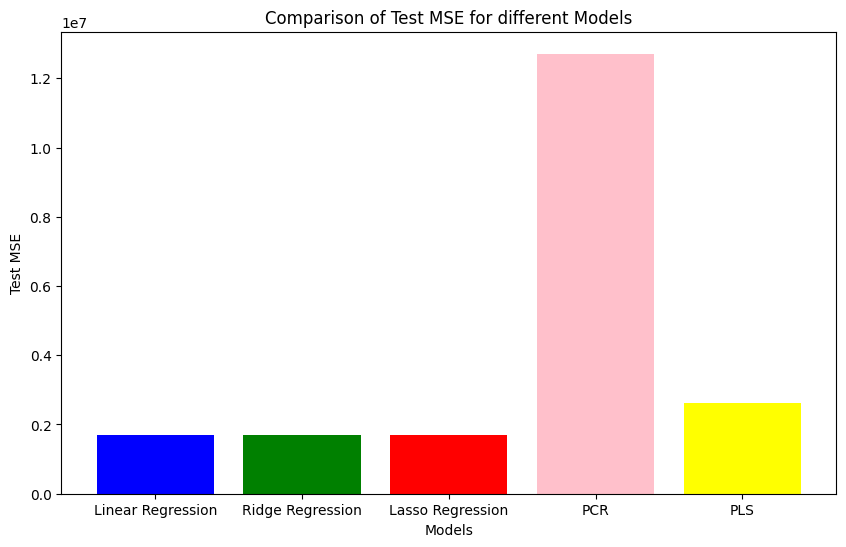

In [44]:
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'PCR', 'PLS']
test_mse_values = [test_mse_lm, test_mse_ridge, test_mse_lasso, test_mse_pcr, test_mse_pls]

plt.figure(figsize=(10, 6))
plt.bar(model_names, test_mse_values, color=['blue', 'green', 'red', 'pink', 'yellow'])
plt.xlabel('Models')
plt.ylabel('Test MSE')
plt.title('Comparison of Test MSE for different Models')
plt.show()
